In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import SALib as salib
from SALib.sample import sobol as salib_sample_sobol
from SALib.analyze import delta, dgsm, fast, ff, hdmr, morris, pawn, rbd_fast, sobol

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import filter_samples

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
emb_suffix = ['_mm', '_em', '_em_wo_migration', '_em_layout', '_em_wo_migration_layout']
file_suffix= ['01', '02', '03', '04', '05', '06', '07', '08', '09']
#file_suffix= ['06', '07', '08', '09']

#emb_suffix_id = 0
#file_suffix_id = 0

list_num_particles = [5, 10]
correct_sol = {'5_particles': np.array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
                                        1.]),
               '10_particles': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
                                        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
                                        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
                                        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
                                        0., 0., 0., 1.])
                }
collection_samples_params = {'{}_parts'.format(n): {'params':{}, 'samples':{}} for n in list_num_particles}
for n_p, num_particles_key in enumerate(collection_samples_params.keys()):
    for file_suffix_id in range(len(file_suffix)):
        collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]] = {}
        collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]] = {}


        folder_path_emb = 'test_analyze_embedding'
        folder_path_emb = os.path.relpath(folder_path_emb)
        data_file_name_emb = 'analyzes_parts_{}_{}.h5'.format(list_num_particles[n_p], file_suffix[file_suffix_id])
        data_file_name_path_emb = os.path.join(folder_path_emb, data_file_name_emb)

        with h5py.File(data_file_name_path_emb, 'r') as f:
            collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]]['embera'] = {'tries': f['embedding_meta/embera_kwargs_diffusion_candidates/tries'][()]}
            collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]]['minorminer'] = {'chainlength_patience': f['embedding_meta/minorminer_kwargs/chainlength_patience'][()],
                                                                                              'max_no_improvement': f['embedding_meta/minorminer_kwargs/max_no_improvement'][()],
                                                                                              'tries': f['embedding_meta/minorminer_kwargs/tries'][()]}
        for emb_suffix_id in range(len(emb_suffix)):
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]] = {}


            print('file_suffix_id:', file_suffix_id, 'emb_suffix_id:', emb_suffix_id)
            print('file_suffix:', file_suffix[file_suffix_id], 'emb_suffix:', emb_suffix[emb_suffix_id])

            folder_path = 'test_embeddings_annealer'
            folder_path = os.path.join('test_embeddings_annealer', 'parts_{}'.format(list_num_particles[n_p]))
            data_file_name = 'embeddingstudy_data_{}_{}_{}.h5'.format(list_num_particles[n_p], emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
            data_file_name_path = os.path.join(folder_path, data_file_name)
            info_file_name = 'embeddingstudy_info_{}_{}_{}.h5'.format(list_num_particles[n_p], emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
            info_file_name_path = os.path.join(folder_path, info_file_name)

            samples_dict = {}
            with h5py.File(data_file_name_path, 'r') as f:
                _ids = [key for key in f['sampleset'].keys()]
                for _id in _ids:
                    #print('set_identifier: ', _id)
                    samples_dict[_id] = f['sampleset'][_id]['sample_data']['data'][()]
            #print(samples_dict[_ids[0]][0])





            counter_valid_samplesets = 0
            ids_valid_samplesets = set()
            counter_valid_and_optimal_samplesets = 0
            ids_valid_and_optimal_samplesets = set()
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_samples'] = []
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_samples'] = []

            for _id in _ids:
                counter_valid_samples = 0
                ids_valid_samples= []
                counter_valid_and_optimal_samples = 0
                ids_valid_and_optimal_samples = []

                for k, sol in enumerate(samples_dict[_id]):
                        parts = 0
                        poss = 0
                        valid_parts = True
                        valid_poss = True
                        for i in range(list_num_particles[n_p]):
                            parts = 0
                            for j in range(list_num_particles[n_p]):
                                parts += sol[i*list_num_particles[n_p] +j]
                            #print('parts ', parts)
                            if parts != 1:
                                valid_parts = False

                        for j in range(list_num_particles[n_p]):
                            poss = 0
                            for i in range(list_num_particles[n_p]):
                                poss += sol[i*list_num_particles[n_p] +j]
                            #print('poss ', poss)
                            if poss != 1:
                                valid_poss = False

                        if valid_parts and valid_poss:
                            ids_valid_samples.append(k)
                            counter_valid_samples += 1
                            ids_valid_samplesets.add(_id)
                            counter_valid_samplesets = len(ids_valid_samplesets)

                for i, sol in enumerate(samples_dict[_id]):
                    if i in ids_valid_samples:
                        if np.array_equal(correct_sol[f'{list_num_particles[n_p]}_particles'].astype(int), sol):
                            ids_valid_and_optimal_samples.append(i)
                            counter_valid_and_optimal_samples += 1
                            ids_valid_and_optimal_samplesets.add(_id)
                            counter_valid_and_optimal_samplesets = len(ids_valid_and_optimal_samplesets)

                if counter_valid_samples == len(ids_valid_samples):
                    collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_samples'].append(ids_valid_samples)
                else:
                    raise ValueError('  WARNING: counter_valid_samples != len(ids_valid_samples)')
                if counter_valid_and_optimal_samples == len(ids_valid_and_optimal_samples):
                    collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_samples'].append(ids_valid_and_optimal_samples)
                else:
                    raise ValueError('  WARNING: counter_valid_and_optimal_samples != len(ids_valid_and_optimal_samples)')

            if counter_valid_samplesets == len(ids_valid_samplesets):
                collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_sets'] = ids_valid_samplesets
            else:
                raise ValueError('  WARNING: counter_valid_samplesets != len(ids_valid_samplesets)')
            if counter_valid_and_optimal_samplesets == len(ids_valid_and_optimal_samplesets):
                collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_sets'] = ids_valid_and_optimal_samplesets
            else:
                raise ValueError('  WARNING: counter_valid_and_optimal_samplesets != len(ids_valid_and_optimal_samplesets)')

            print('  num. valid   samplesets:', counter_valid_samplesets)
            print('  num. correct samplesets:', counter_valid_and_optimal_samplesets)
            print('  num. valid   samples   :', counter_valid_samples)
            print('  num. correct samples   :', counter_valid_and_optimal_samples)




file_suffix_id: 0 emb_suffix_id: 0
file_suffix: 01 emb_suffix: _mm
  num. valid   samplesets: 10
  num. correct samplesets: 10
  num. valid   samples   : 663
  num. correct samples   : 118
file_suffix_id: 0 emb_suffix_id: 1
file_suffix: 01 emb_suffix: _em
  num. valid   samplesets: 10
  num. correct samplesets: 10
  num. valid   samples   : 660
  num. correct samples   : 90
file_suffix_id: 0 emb_suffix_id: 2
file_suffix: 01 emb_suffix: _em_wo_migration
  num. valid   samplesets: 10
  num. correct samplesets: 10
  num. valid   samples   : 665
  num. correct samples   : 158
file_suffix_id: 0 emb_suffix_id: 3
file_suffix: 01 emb_suffix: _em_layout
  num. valid   samplesets: 10
  num. correct samplesets: 10
  num. valid   samples   : 616
  num. correct samples   : 116
file_suffix_id: 0 emb_suffix_id: 4
file_suffix: 01 emb_suffix: _em_wo_migration_layout
  num. valid   samplesets: 10
  num. correct samplesets: 10
  num. valid   samples   : 592
  num. correct samples   : 95
file_suffix_id: 1

In [3]:
print(collection_samples_params['10_parts']['samples']['01']['_mm']['valid_samples'])

[[184], [527, 609, 893], [213], [101, 386, 766], [323], [789, 925], [], [79, 522, 690, 707], [], []]


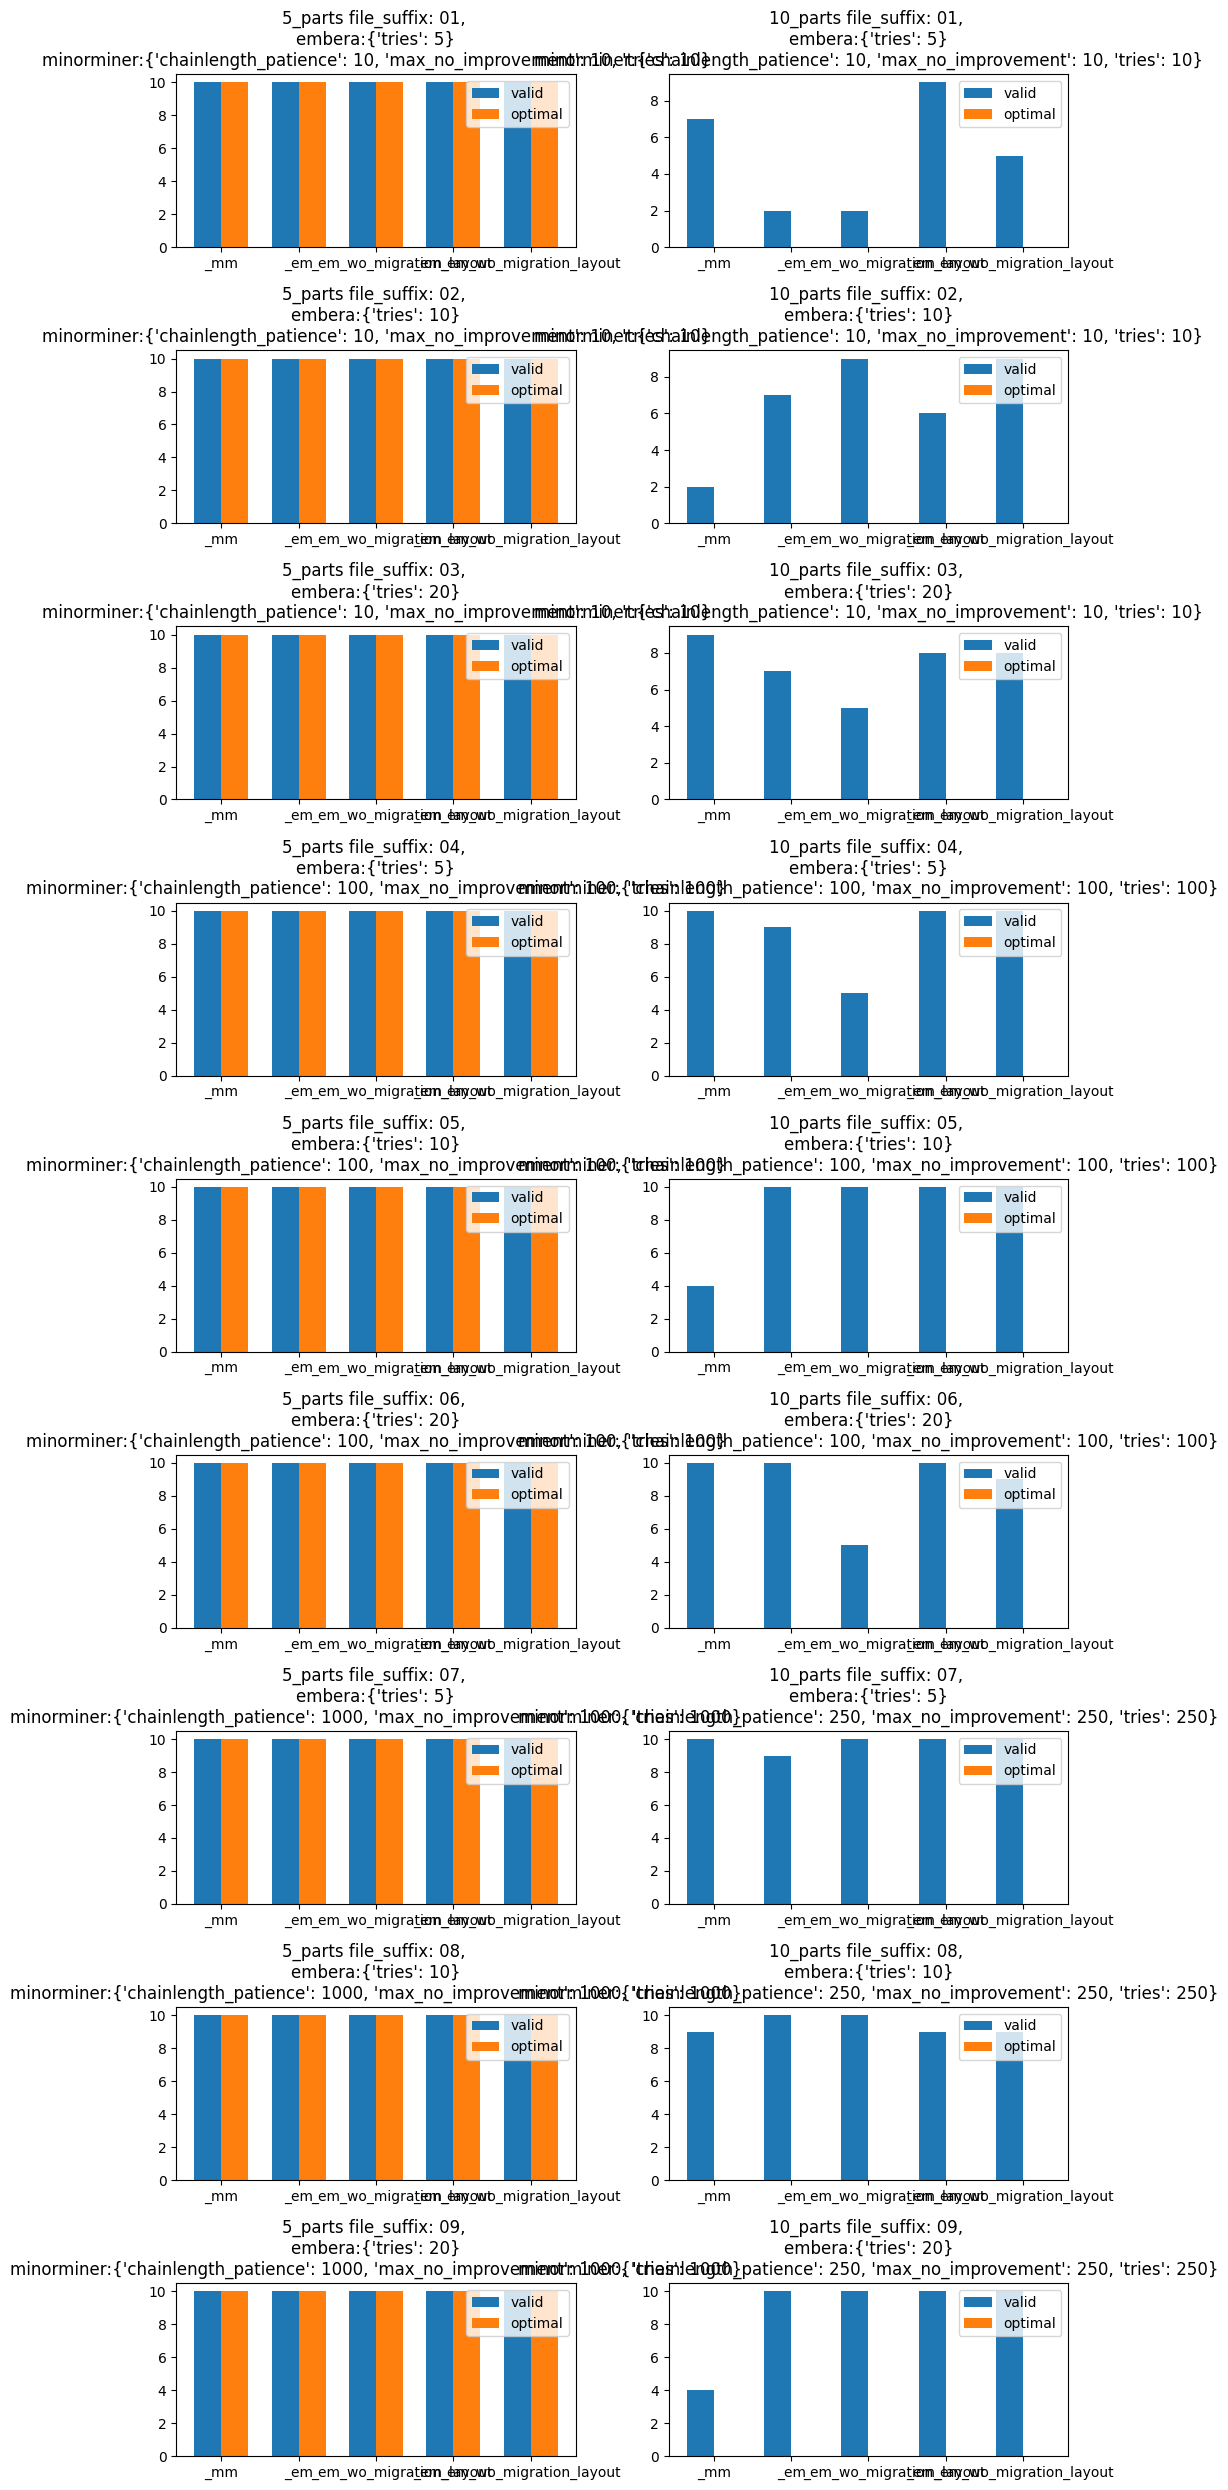

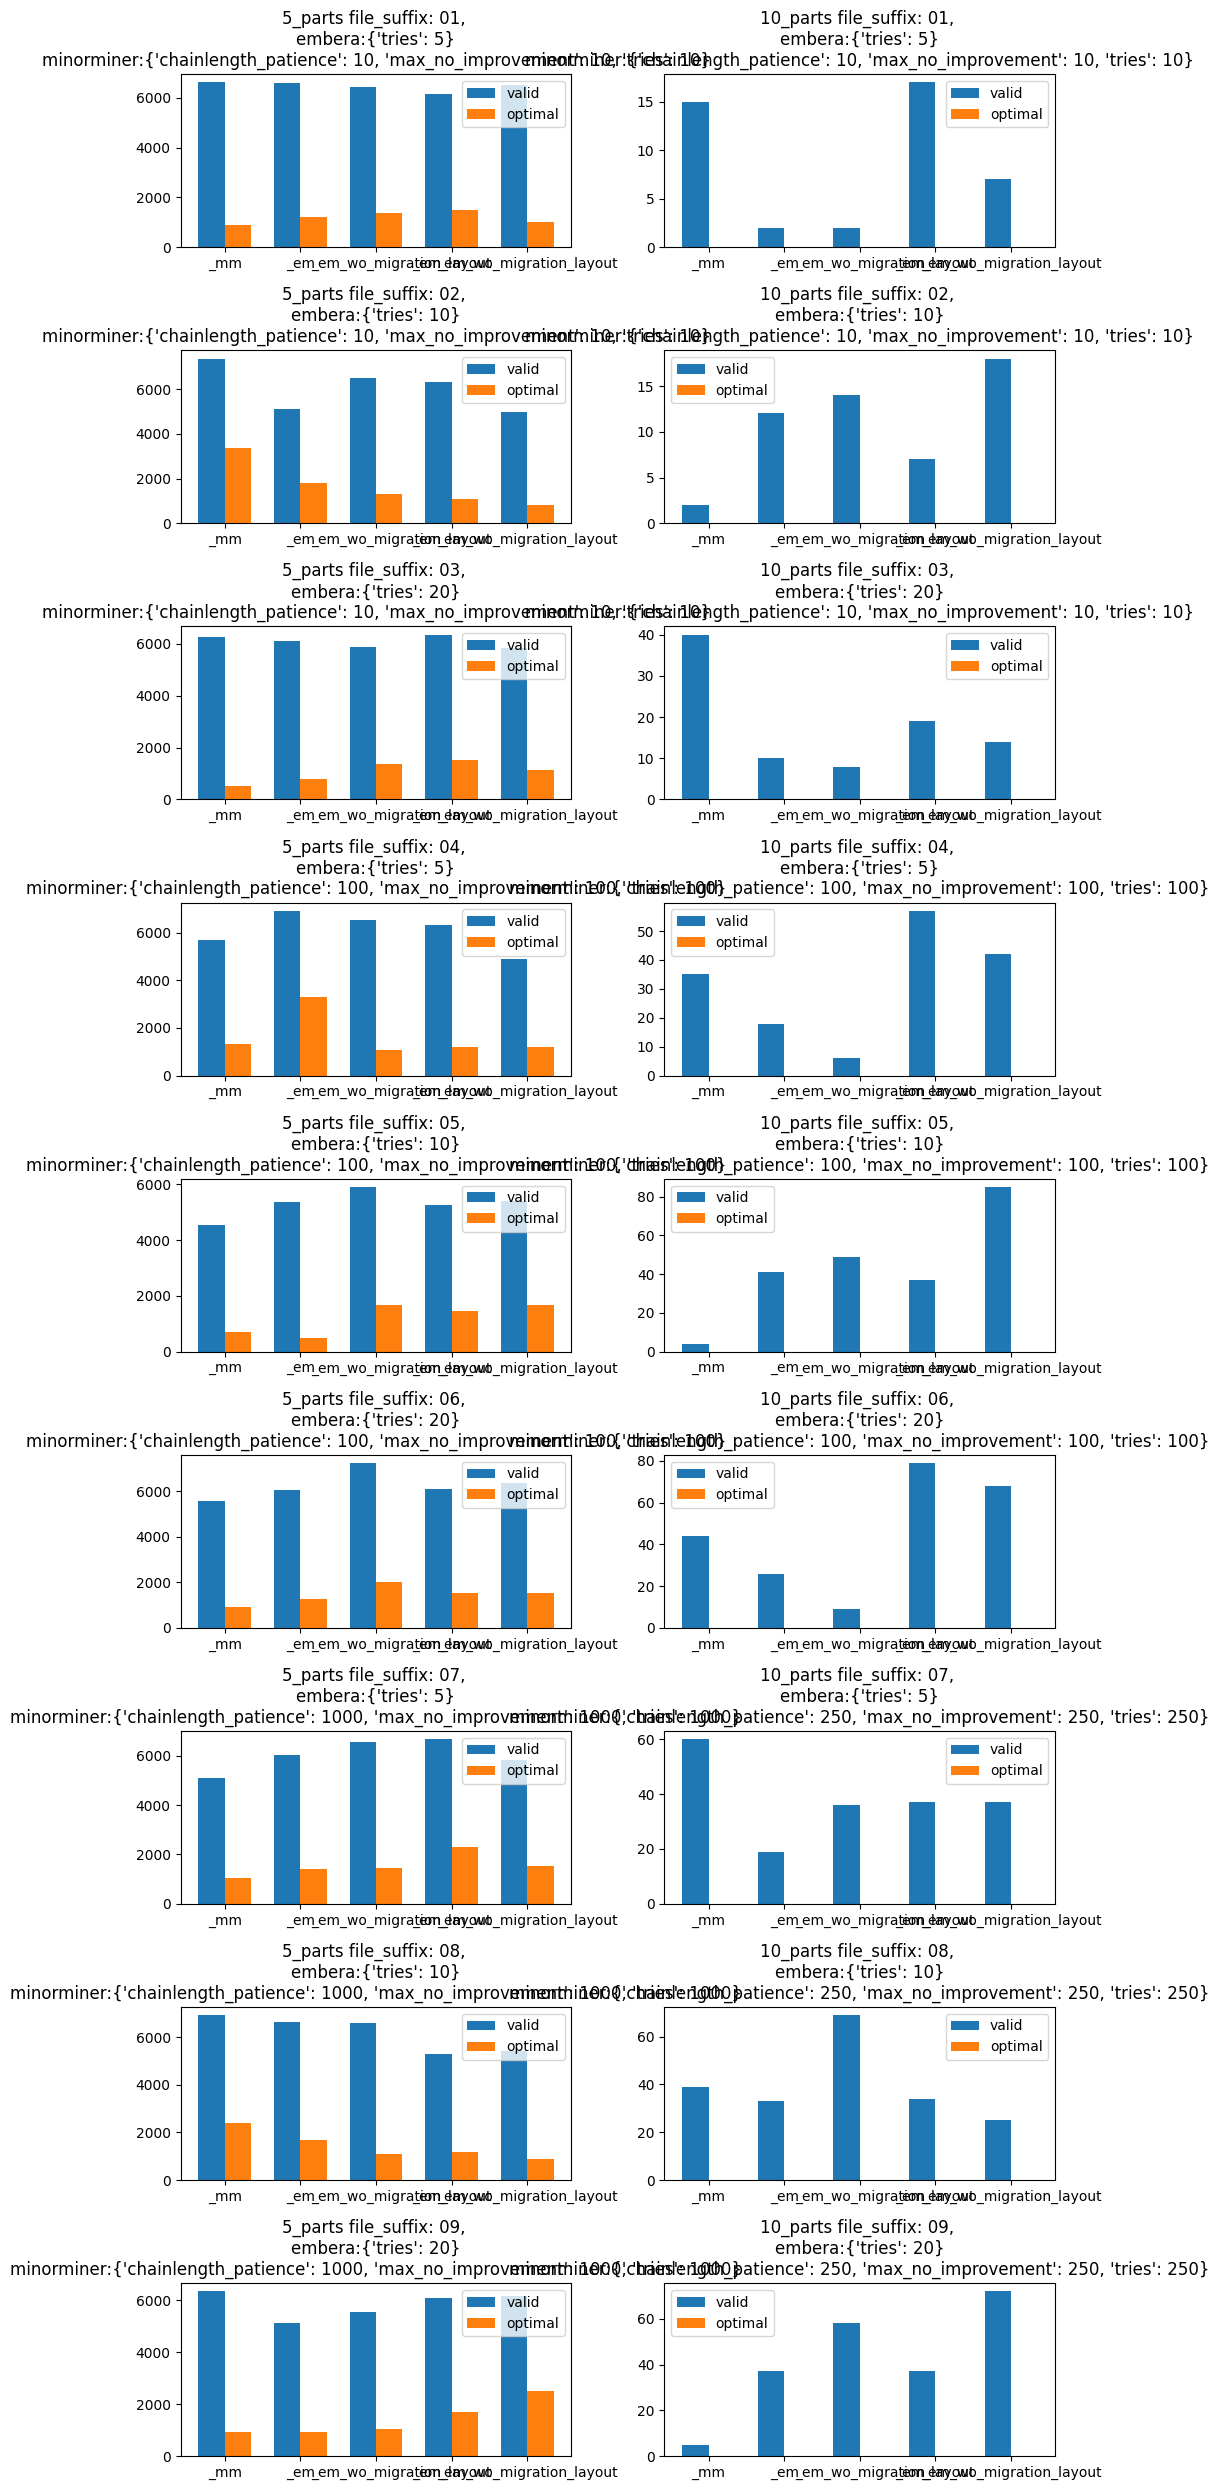

In [4]:
fig_sets, axs_sets = plt.subplots(len(file_suffix), 2, figsize=(10, 25))
fig_samples, axs_samples = plt.subplots(len(file_suffix), 2, figsize=(10, 25))

for n_p, num_particles_key in enumerate(collection_samples_params.keys()):
    for i in range(len(file_suffix)):
        x_poss_0 = np.arange(len(emb_suffix))
        x_labels_0 = emb_suffix
        width_0 = 0.35
        data_1_0 = np.array([len(collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]['valid_sets']) for j in range(len(emb_suffix))])
        data_2_0 = np.array([len(collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]['optimal_sets']) for j in range(len(emb_suffix))])
        title_0 = str(num_particles_key) + ' file_suffix: {}, '.format(file_suffix[i]) \
                + '\n' + 'embera:' + collection_samples_params[num_particles_key]['params'][file_suffix[i]]['embera'].__str__() \
                + '\n' + 'minorminer:' + collection_samples_params[num_particles_key]['params'][file_suffix[i]]['minorminer'].__str__()
        axs_sets[i, n_p].bar(x_poss_0 - width_0/2, data_1_0, width_0, label='valid')
        axs_sets[i, n_p].bar(x_poss_0 + width_0/2, data_2_0, width_0, label='optimal')
        axs_sets[i, n_p].set_xticks(x_poss_0)
        axs_sets[i, n_p].set_xticklabels(x_labels_0)
        axs_sets[i, n_p].set_title(title_0)
        axs_sets[i, n_p].legend()
        x_poss_1 = np.arange(len(emb_suffix))
        x_labels_1 = emb_suffix
        width_1 = 0.35
        data_1_1 = []
        data_2_1 = []
        for j in range(len(emb_suffix)):
            _tmp = collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]
            data_1_1.append(0)
            data_2_1.append(0)
            for k in range(len(_tmp['valid_samples'])):
                data_1_1[j] += len(_tmp['valid_samples'][k])
                data_2_1[j] += len(_tmp['optimal_samples'][k])
        data_1_1 = np.array(data_1_1)
        data_2_1 = np.array(data_2_1)
        title_1 = title_0
        axs_samples[i, n_p].bar(x_poss_1 - width_0/2, data_1_1, width_0, label='valid')
        axs_samples[i, n_p].bar(x_poss_1 + width_0/2, data_2_1, width_0, label='optimal')
        axs_samples[i, n_p].set_xticks(x_poss_1)
        axs_samples[i, n_p].set_xticklabels(x_labels_1)
        axs_samples[i, n_p].set_title(title_1)
        axs_samples[i, n_p].legend()

fig_sets.tight_layout()
fig_samples.tight_layout()